In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor, optim, cuda
from torch.utils.data import TensorDataset, DataLoader

# 데이터 불러오기

In [2]:
# 데이터 로딩
train_X_data = pd.read_csv('./train_set/train_X_data_median.csv', index_col='datetime', parse_dates=True)
test_X_data = pd.read_csv('./test_set/test_X_data_median.csv', index_col='datetime', parse_dates=True)
train_Y_data = pd.read_csv('./train_set/train_Y_data.csv', index_col='datetime', parse_dates=True)
test_Y_data = pd.read_csv('./test_set/test_Y_data.csv', index_col='datetime', parse_dates=True)

test_Y_data_df = test_Y_data

# X 데이터의 모든 열을 숫자형으로 변환
# apply(pd.to_numeric, errors='coerce')를 사용하면 변환되지 않는 값이 NaN으로 변환
train_X_data = train_X_data.apply(pd.to_numeric, errors='coerce') 
test_X_data = test_X_data.apply(pd.to_numeric, errors='coerce')

# 타겟 변수의 'Kp' 열을 숫자형으로 변환
train_Y_data['Kp'] = pd.to_numeric(train_Y_data['Kp'], errors='coerce')
train_Y_data = train_Y_data['Kp'].values.astype(float) # MSELoss를 위해 실수형으로 변환
test_Y_data['Kp'] = pd.to_numeric(test_Y_data['Kp'], errors='coerce')
test_Y_data = test_Y_data['Kp'].values.astype(float) # MSELoss를 위해 실수형으로 변환

# print(train_X_data.head)
# print(train_Y_data.head)

### GPU 사용

In [3]:
if torch.backends.mps.is_available():
    device = 'mps'
    mps_device = torch.device(device)
    torch.cuda.manual_seed_all(777)
    print(device)
else:
    print ("MPS device not found.")

torch.manual_seed(777)

mps


### 정규화

In [4]:
# 데이터 스케일링
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# 훈련 데이터에 대해 스케일러 학습 및 변환
train_X_data = scaler_X.fit_transform(train_X_data)
# train_Y_data = scaler_Y.fit_transform(train_Y_data)

# 테스트 데이터에 대해 스케일러 변환
test_X_data = scaler_X.transform(test_X_data)
# test_Y_data = scaler_Y.transform(test_Y_data)

### Batch 세팅

In [5]:
# 데이터 변환 (torch.Tensor로 변환)
train_X_tensor = torch.tensor(train_X_data, dtype=torch.float32)
train_Y_tensor = torch.tensor(train_Y_data, dtype=torch.float32)

# 배치 크기 정의
batch_size = 256

# TensorDataset과 DataLoader를 사용하여 배치 생성
dataset = TensorDataset(train_X_tensor, train_Y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# MLP Model

In [6]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob):
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_sizes[0])# 첫 번째 선형 계층 정의
        self.batch_norm1 = nn.BatchNorm1d(hidden_sizes[0])# 첫 번째 배치 정규화 계층  (신경망의 학습을 안정화)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.linear2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.batch_norm2 = nn.BatchNorm1d(hidden_sizes[1])
        self.dropout2 = nn.Dropout(dropout_prob)
        self.linear3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.batch_norm3 = nn.BatchNorm1d(hidden_sizes[2])
        self.dropout3 = nn.Dropout(dropout_prob)
        self.linear4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.batch_norm4 = nn.BatchNorm1d(hidden_sizes[3])
        self.dropout4 = nn.Dropout(dropout_prob)
        self.linear5 = nn.Linear(hidden_sizes[3], output_size)

        self.relu = nn.ReLU()

        # Initialize weights using Xavier uniform initialization
        torch.nn.init.xavier_uniform_(self.linear1.weight)# 첫 번째 선형 계층의 가중치를 Xavier uniform 방식으로 초기화
        torch.nn.init.xavier_uniform_(self.linear2.weight)# gradient vanishing(기울기 소실) 및 gradient exploding(기울기 폭발) 문제를 완화
        torch.nn.init.xavier_uniform_(self.linear3.weight)
        torch.nn.init.xavier_uniform_(self.linear4.weight)
        torch.nn.init.xavier_uniform_(self.linear5.weight)

        # Initialize biases to zero
        nn.init.zeros_(self.linear1.bias)# 첫 번째 선형 계층의 편향을 0으로 초기화
        nn.init.zeros_(self.linear2.bias)
        nn.init.zeros_(self.linear3.bias)
        nn.init.zeros_(self.linear4.bias)
        nn.init.zeros_(self.linear5.bias)

    def forward(self, x):
        x = self.linear1(x) # 첫 번째 선형 변환 적용
        x = self.batch_norm1(x)# 첫 번째 배치 정규화 적용
        x = self.relu(x)# ReLU 활성화 함수 적용
        x = self.dropout1(x)

        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.linear3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)
        x = self.dropout3(x)

        x = self.linear4(x)
        x = self.batch_norm4(x)
        x = self.relu(x)
        x = self.dropout4(x)

        x = self.linear5(x)  # No batch norm after the last linear layer
        return x

In [7]:
class WeightedMSELoss(nn.Module):
    def __init__(self):
       super(WeightedMSELoss, self).__init__()


    def forward(self, predictions, targets):
        sum_targets = targets.sum().item()
        if sum_targets == 0:
            return torch.sqrt(torch.tensor(0.001, dtype=torch.float))
        modified_targets = torch.where(targets == 0, torch.tensor(0.8, dtype=targets.dtype), targets)
        weights = modified_targets / sum_targets
        loss = (weights * (predictions - targets).pow(2)).sum()
        return torch.sqrt(loss)

In [8]:
# 모델 초기화
input_size = train_X_data.shape[1]   # input data feature 수, X_train의 열 수
hidden_sizes = [800, 800, 800, 800]
output_size = 1   # output data feature 수, 회귀 문제이므로 출력 크기는 1
dropout_prob=0.8
model = MLPModel(input_size, hidden_sizes, output_size, dropout_prob).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.MSELoss()
criterion = WeightedMSELoss()
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

### Train

In [9]:
def train(dataloader, model, optimizer, criterion, num_epochs=500):
    total_batch = len(dataloader)
    model.train()
    train_loss_list = []  # 손실을 저장할 리스트

    for epoch in range(num_epochs):
        avg_cost = 0

        for X, Y in dataloader:
            optimizer.zero_grad()
            X, Y = X.to(device), Y.to(device)

            prediction = model(X).squeeze()
            loss = criterion(prediction, Y)

            loss.backward()
            optimizer.step()

            avg_cost += loss / total_batch

        train_loss_list.append(avg_cost.item())  # 현재 손실을 리스트에 저장
        print(f'Epoch: {epoch + 1}, cost = {avg_cost:.9f}')

    return train_loss_list  # 손실 리스트 반환

In [10]:
train_loss_list = train(dataloader, model, optimizer, criterion)

Epoch: 1, cost = 2.308062792
Epoch: 2, cost = 1.360579371
Epoch: 3, cost = 1.138894916
Epoch: 4, cost = 1.072601795
Epoch: 5, cost = 1.055291057
Epoch: 6, cost = 1.037990212
Epoch: 7, cost = 1.018728733
Epoch: 8, cost = 1.012652755
Epoch: 9, cost = 1.015926600
Epoch: 10, cost = 1.003552556
Epoch: 11, cost = 0.991660178
Epoch: 12, cost = 0.989404321
Epoch: 13, cost = 0.983386576
Epoch: 14, cost = 0.983067632
Epoch: 15, cost = 0.981013060
Epoch: 16, cost = 0.975878894
Epoch: 17, cost = 0.955413997
Epoch: 18, cost = 0.958802044
Epoch: 19, cost = 0.968686461
Epoch: 20, cost = 0.953275979
Epoch: 21, cost = 0.962981820
Epoch: 22, cost = 0.950492918
Epoch: 23, cost = 0.952850759
Epoch: 24, cost = 0.951655626
Epoch: 25, cost = 0.941659689
Epoch: 26, cost = 0.947422445
Epoch: 27, cost = 0.947949648
Epoch: 28, cost = 0.937194049
Epoch: 29, cost = 0.936901271
Epoch: 30, cost = 0.930696130
Epoch: 31, cost = 0.944085181
Epoch: 32, cost = 0.945640445
Epoch: 33, cost = 0.928962469
Epoch: 34, cost = 0

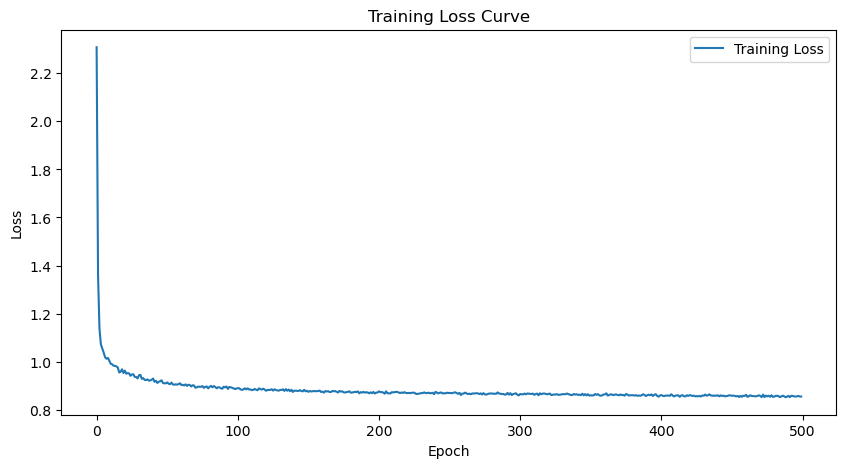

In [11]:
# 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

### Test

In [12]:
test_X_tensor = torch.tensor(test_X_data, dtype=torch.float32)

# TensorDataset과 DataLoader를 사용하여 배치 생성
dataset = TensorDataset(test_X_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [13]:
def evaluate_and_save(dataloader, model, file_path):
    model.eval()  # 모델을 평가 모드로 설정
    predictions = []

    with torch.no_grad():  # 기울기 계산 비활성화
        for X, in dataloader:  # 데이터 로더에서 데이터 배치를 반복
            X = X.to(device)  # 데이터를 적절한 디바이스로 이동 (CPU 또는 GPU)
            output = model(X)  # 모델로부터 예측 수행
            predictions.extend(np.round(output.cpu().numpy()).astype(int))  # 예측값을 리스트에 저장

    # 예측 결과를 DataFrame으로 변환
    predicted_df = pd.DataFrame(predictions, index=test_Y_data_df.index, columns=['Prediction'])
    # 결과를 CSV 파일로 저장
    predicted_df.to_csv(file_path)
    return predicted_df


In [14]:
# 함수 호출
file_path = "./Prediction/MLP_Performance.csv"
y_pred = evaluate_and_save(dataloader, model, file_path)

### 정확도

In [15]:
# WRMSE 함수 정의
def WRMSE(predictions, answers):
    sum_answer = answers.sum().item()  # DataFrame에서 직접 합 계산
    if sum_answer == 0:
        return torch.sqrt(torch.tensor(0.001, dtype=torch.float))
    weights = answers / sum_answer  # 각 값에 대해 가중치 계산
    loss = (weights * (predictions - answers).pow(2)).sum().item()  # 가중치 적용한 오차 제곱합
    return torch.sqrt(torch.tensor(loss, dtype=torch.float))

In [24]:
test_rmse = np.sqrt(mean_squared_error(test_Y_data, y_pred))

print(f'Test RMSE: {test_rmse}')

# 텐서 변환
test_targets_tensor = torch.tensor(test_Y_data_df['Kp'].values, dtype=torch.float32)
test_predictions_tensor = torch.tensor(y_pred['Prediction'].values, dtype=torch.float32)

# WRMSE 계산
wrmse_value = WRMSE(test_predictions_tensor, test_targets_tensor)
print(f'Test WRMSE: {wrmse_value.item()}')

# R²
RS_r2 = r2_score(test_Y_data, y_pred)
print(f'Test R²: {RS_r2}')

# MAE
RS_mae = mean_absolute_error(test_Y_data, y_pred)
print(f'Test MAE: {RS_mae}')

Test RMSE: 0.7831705844728604
Test WRMSE: 0.7387509942054749
Test R²: 0.5321189365451315
Test MAE: 0.5448630136986301


In [ ]:
test_rmse = np.sqrt(mean_squared_error(test_Y_data, y_pred))

print(f'Test RMSE: {test_rmse}')

# 텐서 변환
test_targets_tensor = torch.tensor(test_Y_data_df['Kp'].values, dtype=torch.float32)
test_predictions_tensor = torch.tensor(y_pred['Prediction'].values, dtype=torch.float32)

# WRMSE 계산
wrmse_value = WRMSE(test_predictions_tensor, test_targets_tensor)
print(f'Test WRMSE: {wrmse_value.item()}')

# R²
RS_r2 = r2_score(test_Y_data, y_pred)
print(f'Test R²: {RS_r2}')

# MAE
RS_mae = mean_absolute_error(test_Y_data, y_pred)
print(f'Test MAE: {RS_mae}')

Test RMSE: 0.7831705844728604
Test WRMSE: 0.7387509942054749
Test R²: 0.5321189365451315
Test MAE: 0.5448630136986301


### 시각화

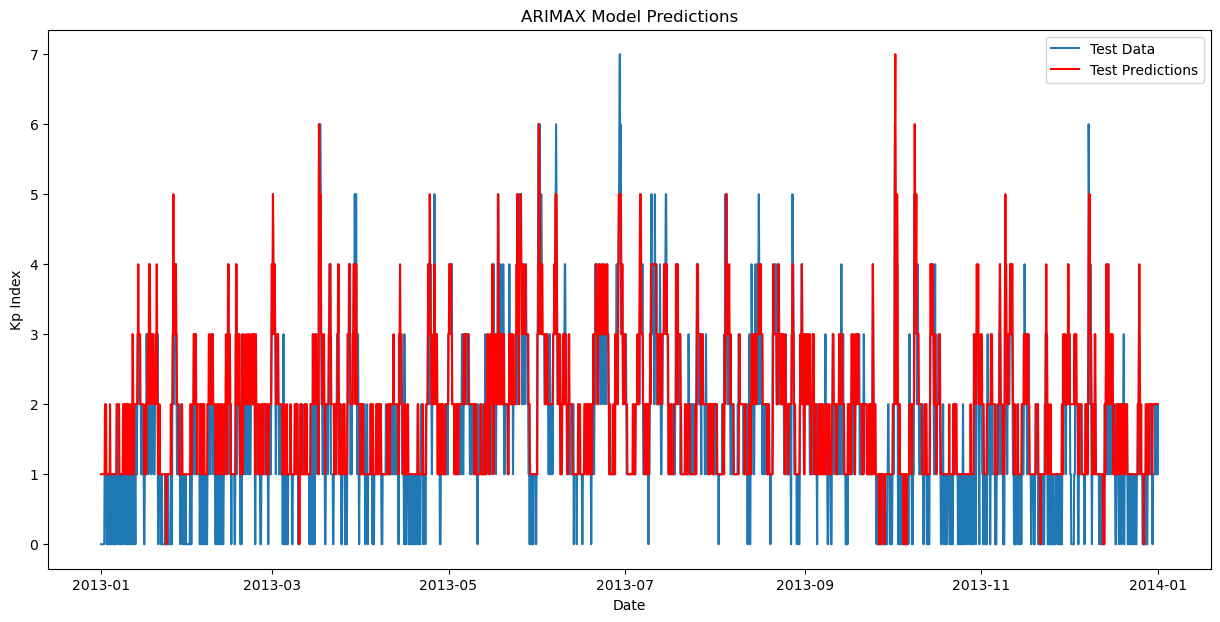

In [17]:
plt.figure(figsize=(15, 7))
plt.plot(test_Y_data_df, label='Test Data')
plt.plot(y_pred, label='Test Predictions', color='red')
plt.title('ARIMAX Model Predictions')
plt.xlabel('Date')
plt.ylabel('Kp Index')
plt.legend()
plt.show()

In [22]:
print(type(y_pred))
y_pred.to_csv('./MLP_Prediction/MLP_median.csv')

<class 'pandas.core.frame.DataFrame'>


In [19]:
def print_model_summary(model):
    """
    Prints the summary of a PyTorch nn.Module model, including its layers and parameters.

    Parameters:
    model (nn.Module): The PyTorch model to summarize.

    """
    for name, layer in model.named_children():
        print(f"Layer: {name}")
        print(f"Type: {type(layer)}")
        for param_name, param in layer.named_parameters():
            print(f"    Parameter: {param_name}, Shape: {param.shape}")

In [20]:
print_model_summary(model)

Layer: linear1
Type: <class 'torch.nn.modules.linear.Linear'>
    Parameter: weight, Shape: torch.Size([800, 35])
    Parameter: bias, Shape: torch.Size([800])
Layer: batch_norm1
Type: <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
    Parameter: weight, Shape: torch.Size([800])
    Parameter: bias, Shape: torch.Size([800])
Layer: dropout1
Type: <class 'torch.nn.modules.dropout.Dropout'>
Layer: linear2
Type: <class 'torch.nn.modules.linear.Linear'>
    Parameter: weight, Shape: torch.Size([800, 800])
    Parameter: bias, Shape: torch.Size([800])
Layer: batch_norm2
Type: <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
    Parameter: weight, Shape: torch.Size([800])
    Parameter: bias, Shape: torch.Size([800])
Layer: dropout2
Type: <class 'torch.nn.modules.dropout.Dropout'>
Layer: linear3
Type: <class 'torch.nn.modules.linear.Linear'>
    Parameter: weight, Shape: torch.Size([800, 800])
    Parameter: bias, Shape: torch.Size([800])
Layer: batch_norm3
Type: <class 'torch.nn.modules.ba